### PRE-ENTREGA 3


Grupo 15

Belen Massuco - Andrea Rodriguez

Fecha de entrega: 18 de junio 2025

INTRODUCCI√ìN

Para nuestro proyecto final, seleccionamos un dataset de estad√≠sticas agr√≠colas hist√≥ricas de Argentina, proveniente del portal oficial del Ministerio de Agricultura. Este dataset incluye registros desde el ciclo agr√≠cola 1969/1970 hasta 2022/2023, con informaci√≥n organizada por provincia y departamento. Las variables principales son:

- provincia_nombre: Nombre de la provincia
- departamento_nombre: Nombre del departamento
- cultivo: Nombre del cultivo
- ciclo: A√±o de la campa√±a
- sup_sembrada: Cantidad de superficie semabrada en hectareas
- sup_cosechada: Cantidad de superficie cosechada en hectareas
- produccion: Cantidad de produccion en toneladas
- rendimiento: Cantidad de rendimiento en kilos por hectarea

Fuente dataset: https://datos.magyp.gob.ar/dataset/estimaciones-agricolas

En esta etapa se trabaj√≥ sobre:
- Modelo de aprendizaje supervisado.
- Ajuste de modelos de clasificaci√≥n o regresi√≥n.
- Evaluaci√≥n de los modelos.
- Optimizaci√≥n de hiperpar√°metros.

OBJETIVO:

Predecir la producci√≥n de los 3 cultivos con mayor producci√≥n hist√≥rica.



### Cargamos librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Cargamos y exploramos dataset

Se trabaja con mismo dataset de la pre-entrega 2

In [3]:
# Importar dataset
df = pd.read_csv('estimaciones_agricolas.csv', encoding='latin1', delimiter=',', dtype={9: object, 10: object, 11: object})

In [4]:
# Mostrar primeras observaciones
df.head()

provincia_id provincia_nombre  departamento_id     departamento_nombre  \
0             6     Buenos Aires              854              25 de Mayo   
1             6     Buenos Aires               14  Adolfo Gonzales Chaves   
2             6     Buenos Aires               21                 Alberti   
3             6     Buenos Aires               28         Almirante Brown   
4             6     Buenos Aires               77               Arrecifes   

   id_cultivo cultivo  id_ciclo      ciclo  sup_sembrada sup_cosechada  \
0         1.0     Ajo         1  1969/1970             3             3   
1         1.0     Ajo         1  1969/1970            15            15   
2         1.0     Ajo         1  1969/1970             5             5   
3         1.0     Ajo         1  1969/1970             2             2   
4         1.0     Ajo         1  1969/1970             6             6   

  produccion rendimiento  
0         10        3333  
1         82        5467  
2          7        1400  
3          8        4000  
4         15        2500

In [5]:
# Mostrar cantidad de registros/observaciones y features
ff = df.shape
print(f'El dataset contiene {ff[0]} observaciones y {ff[1]} features.')

El dataset contiene 153889 observaciones y 12 features.


In [6]:
# Ver tipos de datos
df.dtypes

provincia_id             int64
provincia_nombre        object
departamento_id          int64
departamento_nombre     object
id_cultivo             float64
cultivo                 object
id_ciclo                 int64
ciclo                   object
sup_sembrada             int64
sup_cosechada           object
produccion              object
rendimiento             object
dtype: object

In [7]:
# Nombre de features
df.columns

Index(['provincia_id', 'provincia_nombre', 'departamento_id',
       'departamento_nombre', 'id_cultivo', 'cultivo', 'id_ciclo', 'ciclo',
       'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento'],
      dtype='object')

In [8]:
# Renombrar features - agregar unidades
df.rename(columns={'sup_sembrada': 'sup_sembrada_ha', 'sup_cosechada': 'sup_cosechada_ha', 'produccion': 'produccion_ton', 'rendimiento':'rendimiento_kg/ha'}, inplace=True)

In [9]:
# Se convierten las columnas sup_cosechada_ha', 'produccion_ton' y 'rendimiento_kg/ha' de object a float/int
columns_to_convert = ['sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Limpiar y convertir a float/int
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # eliminar separadores de miles
    df[col] = df[col].str.replace(',', '.', regex=False)             # cambiar coma decimal por punto
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
# Verificar resultado
print(df[columns_to_convert].dtypes)

sup_cosechada_ha     float64
produccion_ton       float64
rendimiento_kg/ha    float64
dtype: object


### Creaci√≥n y selecci√≥n de features

**Regi√≥n**

In [11]:
# Diccionario de provincias agrupadas por regi√≥n
region_map = {
    'Santiago del Estero': 'NOA',
    'Tucuman': 'NOA',
    'Catamarca': 'NOA',
    'Jujuy': 'NOA',
    'Salta': 'NOA',
    'La Rioja': 'NOA',

    'Chaco': 'NEA',
    'Corrientes': 'NEA',
    'Formosa': 'NEA',
    'Misiones': 'NEA',

    'Buenos Aires': 'Pampeana',
    'Santa Fe': 'Pampeana',
    'Cordoba': 'Pampeana',
    'Entre Rios': 'Pampeana',
    'La Pampa': 'Pampeana',


    'Mendoza': 'Cuyo',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',

    'Neuquen': 'Patagonia',
    'Rio Negro': 'Patagonia',
    'Chubut': 'Patagonia',
    'Santa Cruz': 'Patagonia',
    'Tierra del Fuego': 'Patagonia'
}

In [12]:
df['region'] = df['provincia_nombre'].map(region_map)

**Tasa de cosecha**

In [13]:
df['tasa_cosecha'] = df['sup_cosechada_ha'] / df['sup_sembrada_ha']

**A√±o**

In [14]:
df['anio'] = df['ciclo'].str[:4].astype(int)

*Se eliminan columnas*.

- provincia_nombre: se elimina porque se decide trabajar por regiones d√≥nde √©stas ya son representadas.
- provincia_id: se elimina porque ya no aporta valor.
- departamento_id: no sera √∫til en este an√°lisis
- departamento_nombre: no sera √∫til en este an√°lisis
- id_ciclo: no ser√° √∫til en este an√°lisis
- ciclo: la reemplaza la feature anio
- id_cultivo: no ser√° √∫til en este an√°lisis

*Para el an√°lisis se usaran*:

- 'region'
- 'cultivo'
- 'sup_sembrada_ha'
- 'sup_cosechada_ha'
- 'produccion_ton'
- 'rendimiento_kg/ha'
- 'tasa_cosecha'
- 'anio'

In [15]:
df.drop(columns=['provincia_id', 'provincia_nombre', 'departamento_id', 'departamento_nombre',
                 'id_ciclo', 'ciclo', 'id_cultivo'], inplace=True)

### Estad√≠stica descriptiva de variables num√©ricas

Analizamos las principales variables cuantitativas del dataset: superficie sembrada y cosechada (en hect√°reas), producci√≥n total (en toneladas), rendimiento (en kg/ha) y tasa de cosecha (cosechada / sembrada).

In [16]:
print(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']].describe())

       sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
count     1.538890e+05      1.538760e+05    1.538750e+05      153875.000000   
mean      1.228560e+04      1.075362e+04    3.331973e+04        3489.310772   
std       3.585014e+04      3.436686e+04    1.276209e+05        5577.586344   
min       0.000000e+00      0.000000e+00    0.000000e+00           0.000000   
25%       1.800000e+02      6.100000e+01    1.800000e+02        1000.000000   
50%       1.439000e+03      8.000000e+02    1.790000e+03        1919.000000   
75%       8.500000e+03      6.000000e+03    1.400000e+04        3501.000000   
max       1.096100e+06      1.066100e+06    8.620000e+06      300000.000000   

       tasa_cosecha  
count  1.506520e+05  
mean            inf  
std             NaN  
min    0.000000e+00  
25%    6.551724e-01  
50%    9.636364e-01  
75%    1.000000e+00  
max             inf  


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


El m√≠nimo para las variables analizadas result√≥ cero.


In [17]:
# Contar valores igual a cero
(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']] == 0).sum()


sup_sembrada_ha       3225
sup_cosechada_ha     16314
produccion_ton       13147
rendimiento_kg/ha    16348
tasa_cosecha         13090
dtype: int64

Chequeo de valores nulos en la feature "sup_sembrada_ha" ya que el m√≠nimo estad√≠stico es cero

In [18]:
df['sup_sembrada_ha'].sort_values().head(5)

3338    0
3339    0
3340    0
3341    0
3342    0
Name: sup_sembrada_ha, dtype: int64

Aunque el resumen estad√≠stico muestra un valor m√≠nimo de 0 en la superficie sembrada, al inspeccionar los registros m√°s bajos se comprob√≥ que no existen valores nulos reales. Los valores m√≠nimos observados son de 1 o 2 hect√°reas, lo que puede corresponder a registros de peque√±a escala. Por lo tanto, se concluye que la superficie sembrada siempre fue mayor que cero en los datos analizados.

Mostrar filas con datos con valor cero

In [19]:
df[(df['sup_cosechada_ha'] == 0) |
   (df['produccion_ton'] == 0) |
   (df['rendimiento_kg/ha'] == 0) |
   (df['tasa_cosecha'] == 0)]

cultivo  sup_sembrada_ha  sup_cosechada_ha  produccion_ton  \
307         Algod√≥n                6               0.0             0.0   
410         Alpiste              100               0.0             0.0   
496           Avena             2500               0.0             0.0   
498           Avena              100               0.0             0.0   
501           Avena             3000               0.0             0.0   
...             ...              ...               ...             ...   
153492        Sorgo             1000               0.0             0.0   
153567        Sorgo              450               0.0             0.0   
153754  Trigo total                0               0.0             0.0   
153796  Trigo total                0               0.0             0.0   
153798  Trigo total                0               0.0             0.0   

        rendimiento_kg/ha    region  tasa_cosecha  anio  
307                   0.0       NOA           0.0  1969  
410                   0.0  Pampeana           0.0  1969  
496                   0.0  Pampeana           0.0  1969  
498                   0.0  Pampeana           0.0  1969  
501                   0.0  Pampeana           0.0  1969  
...                   ...       ...           ...   ...  
153492                0.0  Pampeana           0.0  2022  
153567                0.0       NOA           0.0  2022  
153754                0.0       NEA           NaN  2022  
153796                0.0       NOA           NaN  2022  
153798                0.0       NOA           NaN  2022  

[16348 rows x 8 columns]

Durante el an√°lisis exploratorio, se identificaron registros en los que la superficie sembrada es distinta de cero, pero no se registra superficie cosechada. Estos casos pueden deberse a p√©rdidas totales por eventos clim√°ticos, abandono del cultivo, decisiones econ√≥micas o errores en la carga de datos.

Dado que representan situaciones reales del proceso agr√≠cola, se decidi√≥ conservarlos en esta etapa con el objetivo de evaluar su impacto potencial en el modelo de machine learning que se desarrollar√° posteriormente. Su inclusi√≥n permitir√° analizar si estas situaciones extremas contienen informaci√≥n √∫til para la predicci√≥n o si, por el contrario, generan ruido que justifique su exclusi√≥n futura.

### An√°lisis por cultivo

**Chequeo de cultivos**: cantidad de cultivos 42





In [20]:
df['cultivo'].nunique()

42

Con el objetivo de enfocar el an√°lisis en los cultivos de mayor impacto productivo a nivel nacional, se procedi√≥ a identificar aquellos con la mayor producci√≥n total acumulada en el per√≠odo disponible. Para ello, se agruparon los datos por tipo de cultivo y se sum√≥ la producci√≥n total en toneladas.

In [21]:
# Se agrupan los datos por cultivo y se suma por feature produccion
cultivos_produccion = df.groupby('cultivo')['produccion_ton'].sum().reset_index()

# Ordenamos por produccion en orden descendente
cultivos_produccion = cultivos_produccion.sort_values(by='produccion_ton', ascending=False)

# Se muestran los cultivos con mayor hect√°rea sembrada
print("Cultivos con mayor producci√≥n a nivel nacional:")
print(cultivos_produccion.head(4))

Cultivos con mayor producci√≥n a nivel nacional:
        cultivo  produccion_ton
35   Soja total    1.224195e+09
23         Ma√≠z    1.039261e+09
33     Soja 1ra    8.240707e+08
38  Trigo total    6.373855e+08


'Soja 1ra' no se va a considerar ya que est√° inclu√≠da en 'Soja total'

A partir de este an√°lisis, se seleccionaron los tres cultivos con mayor volumen de producci√≥n como subconjunto de inter√©s.

In [22]:
# Filtramos dataset considerando s√≥lo 3 cultivos
df.drop(df[~df['cultivo'].isin(['Soja total', 'Ma√≠z', 'Trigo total'])].index, inplace=True)

In [23]:
df['cultivo'].unique()

array(['Ma√≠z', 'Soja total', 'Trigo total'], dtype=object)

Chequeo valores nulos en el nuevo dataset

In [24]:
df.isnull().sum()

cultivo              0
sup_sembrada_ha      0
sup_cosechada_ha     1
produccion_ton       2
rendimiento_kg/ha    2
region               0
tasa_cosecha         4
anio                 0
dtype: int64

No hay valores nulos

In [25]:
df[df.isna().any(axis=1)]

cultivo  sup_sembrada_ha  sup_cosechada_ha  produccion_ton  \
139560         Ma√≠z             2200               NaN             NaN   
140106         Ma√≠z              100             100.0             NaN   
153754  Trigo total                0               0.0             0.0   
153796  Trigo total                0               0.0             0.0   
153798  Trigo total                0               0.0             0.0   

        rendimiento_kg/ha    region  tasa_cosecha  anio  
139560                NaN  Pampeana           NaN  2017  
140106                NaN       NOA           1.0  2017  
153754                0.0       NEA           NaN  2022  
153796                0.0       NOA           NaN  2022  
153798                0.0       NOA           NaN  2022

Hay 5 filas con variables num√©ricas igual a cero o NaN

In [26]:
df['sup_sembrada_ha'].sort_values().head(5)

153798    0
153796    0
153754    0
6549      1
11652     1
Name: sup_sembrada_ha, dtype: int64

Superfice sembrada tiene 3 filas nulas. Este valor no se puede recuperar por eso se decide eliminar estas filas.

In [27]:
df = df[df['sup_sembrada_ha'] != 0]

In [28]:
df[df.isna().any(axis=1)]

cultivo  sup_sembrada_ha  sup_cosechada_ha  produccion_ton  \
139560    Ma√≠z             2200               NaN             NaN   
140106    Ma√≠z              100             100.0             NaN   

        rendimiento_kg/ha    region  tasa_cosecha  anio  
139560                NaN  Pampeana           NaN  2017  
140106                NaN       NOA           1.0  2017

Como hay 2 filas con valores NaN en producci√≥n pero adem√°s en rendimiento, se decide eliminarlas ya que no se pueden recuperar con precisi√≥n.

In [29]:
df = df.dropna(subset=['produccion_ton'])

In [30]:
# Chequeo de filas con valores cero o NaN
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [cultivo, sup_sembrada_ha, sup_cosechada_ha, produccion_ton, rendimiento_kg/ha, region, tasa_cosecha, anio]
Index: []

In [31]:
# Mostrar cantidad de registros/observaciones y features
ff = df.shape
print(f'El dataset contiene {ff[0]} observaciones y {ff[1]} features.')

El dataset contiene 41271 observaciones y 8 features.


Se eliminaron las filas con valores 'NaN', son s√≥lo 5 filas en una base de datos de arriba de 40mil observaciones. Adem√°s, no hay suficiente informaci√≥n contextual para estimarlos de forma confiable.

Se continua con la visualizaci√≥n de los datos

### Visualizaci√≥n de datos

Estad√≠sticas de variables num√©ricas

In [32]:
print(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']].describe())

       sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
count     4.127100e+04      4.127100e+04    4.127100e+04       41271.000000   
mean      2.507804e+04      2.313258e+04    7.028765e+04        2672.677086   
std       5.356877e+04      5.174875e+04    1.742528e+05        1889.604017   
min       1.000000e+00      0.000000e+00    0.000000e+00           0.000000   
25%       1.000000e+03      7.000000e+02    1.300000e+03        1443.000000   
50%       5.700000e+03      4.700000e+03    1.160000e+04        2125.000000   
75%       2.600000e+04      2.250000e+04    6.350000e+04        3290.500000   
max       1.096100e+06      1.066100e+06    3.412500e+06       33333.000000   

       tasa_cosecha  
count  41271.000000  
mean       0.856121  
std        0.238476  
min        0.000000  
25%        0.827586  
50%        0.972727  
75%        1.000000  
max        1.001961  


El dataset contiene 41.271 registros con gran variabilidad en las variables clave. La superficie sembrada y cosechada promedian alrededor de 25.000 y 23.000 hect√°reas, respectivamente, con rangos que van desde parcelas muy peque√±as hasta extensas superficies. La producci√≥n media es de 70.000 toneladas, aunque con valores muy dispersos y algunos extremos muy altos. El rendimiento promedio es de 2.673 kg/ha, mostrando amplia variabilidad, desde cero hasta casos excepcionales. La tasa de cosecha ronda el 86%, con algunos registros de cosecha nula o ligeramente superiores al 100%, posiblemente por errores o ajustes.

Filtramos dataset para visualizaci√≥n de datos seg√∫n regi√≥n y cultivo

In [33]:
region_data = df.groupby(['region','cultivo'])[['produccion_ton', 'rendimiento_kg/ha', 'sup_sembrada_ha', 'sup_cosechada_ha', 'tasa_cosecha']].sum().reset_index()
print(f'{region_data}')

       region      cultivo  produccion_ton  rendimiento_kg/ha  \
0        Cuyo         Ma√≠z    2.892310e+07          1868561.0   
1        Cuyo   Soja total    9.553981e+06           334859.0   
2        Cuyo  Trigo total    6.441030e+05           455488.0   
3         NEA         Ma√≠z    2.541552e+07          7240223.0   
4         NEA   Soja total    3.222777e+07          3415366.0   
5         NEA  Trigo total    4.104932e+06          1375849.0   
6         NOA         Ma√≠z    9.341597e+07          9619251.0   
7         NOA   Soja total    9.858979e+07          4000308.0   
8         NOA  Trigo total    1.837150e+07          2815351.0   
9    Pampeana         Ma√≠z    8.913983e+08         42542465.0   
10   Pampeana   Soja total    1.083823e+09         15585515.0   
11   Pampeana  Trigo total    6.141075e+08         20152545.0   
12  Patagonia         Ma√≠z    1.083120e+05           612210.0   
13  Patagonia  Trigo total    1.574810e+05           286065.0   

    sup_sembrada_ha

Se decide eliminar la regi√≥n 'Patagonia', ya que contiene valores con varios ordenes de magnitud menor en comparaci√≥n a otras regiones, por tanto el aporte no es significativo.

In [34]:
df.drop(df[df['region'] == 'Patagonia'].index, inplace=True)

Se grafican para los 3 cultivos

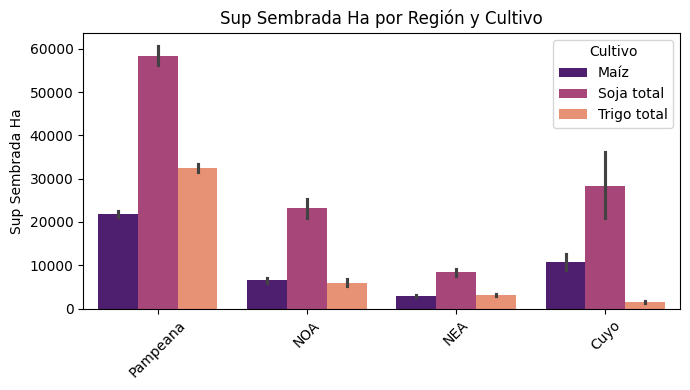

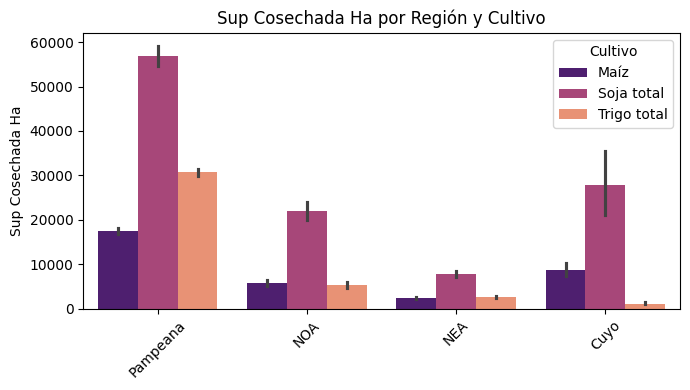

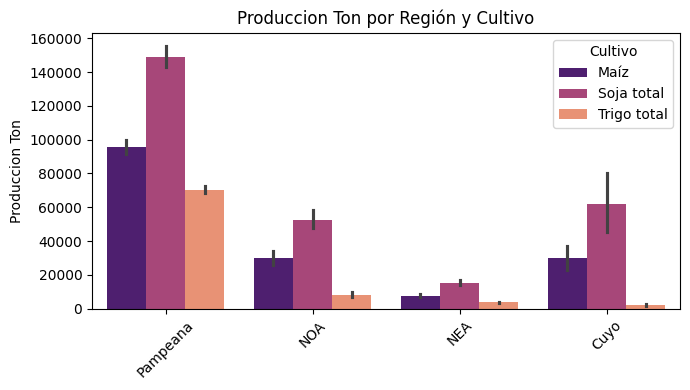

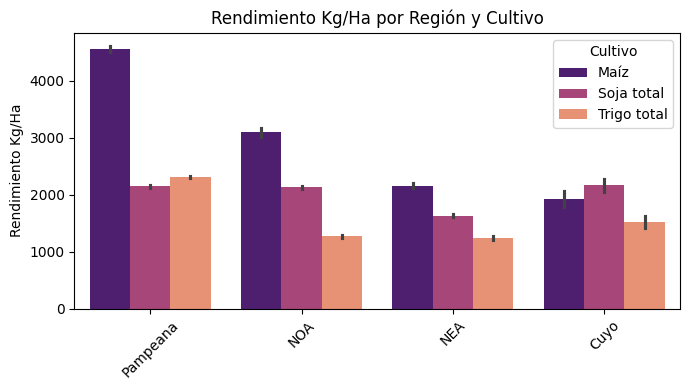

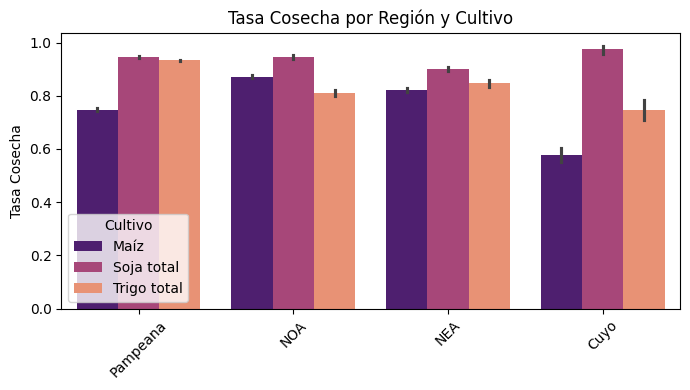

In [35]:
# Gr√°ficamos para cada m√©trica
for metric in ['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']:
    plt.figure(figsize=(7, 4))
    sns.barplot(x='region', y=metric, hue='cultivo', data=df, palette='magma')
    plt.title(f'{metric.replace("_", " ").title()} por Regi√≥n y Cultivo')
    plt.xlabel('')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.legend(title='Cultivo')
    plt.tight_layout()
    plt.savefig(f'{metric.replace("/", "_")}_por_region_y_cultivo.png')
    plt.show()

üå± Superficie sembrada por regi√≥n y cultivo

La regi√≥n Pampeana concentra ampliamente la mayor parte de la superficie sembrada para los tres cultivos, destac√°ndose la soja con m√°s de 60.000 hect√°reas. Le sigue el trigo y luego el ma√≠z. En las dem√°s regiones, la superficie sembrada es notablemente menor, aunque Cuyo y NOA muestran una participaci√≥n importante en soja. El trigo y el ma√≠z tienen menor presencia en NEA y Cuyo, reflejando diferencias agroecol√≥gicas y de estrategia productiva regional.

üåæ Superficie cosechada

La distribuci√≥n de la superficie cosechada replica el patr√≥n de la siembra, indicando que la mayor√≠a de la superficie sembrada efectivamente se cosecha, especialmente en la regi√≥n Pampeana. Se observan leves diferencias en otras regiones, como en Cuyo, donde la superficie cosechada de trigo es sensiblemente menor a la sembrada, lo que podr√≠a estar asociado a condiciones clim√°ticas adversas o limitaciones operativas.

üìà Producci√≥n total

La producci√≥n sigue la tendencia de la superficie y los rendimientos: la soja en la regi√≥n Pampeana es el cultivo estrella, con valores de producci√≥n que superan las 140.000 toneladas. El ma√≠z tambi√©n alcanza altos vol√∫menes, seguido por el trigo. En NOA y Cuyo, la soja tambi√©n lidera, aunque con menor volumen. En general, el peso de la regi√≥n Pampeana en la producci√≥n nacional es indiscutible.

‚öñÔ∏è Rendimiento (Kg/Ha)

Los mayores rendimientos se alcanzan con el ma√≠z en la regi√≥n Pampeana (m√°s de 4.500 kg/ha), lo que evidencia un manejo t√©cnico eficiente y condiciones agroclim√°ticas √≥ptimas. La soja y el trigo tienen rendimientos m√°s bajos y estables, aunque la soja en Cuyo sorprende con un buen desempe√±o. En cambio, el trigo en NOA y NEA muestra los valores m√°s bajos, evidenciando limitantes agron√≥micas o clim√°ticas.

‚úÖ Tasa de cosecha

La tasa de cosecha es alta en la mayor√≠a de las regiones y cultivos, con valores cercanos al 1 (100%), lo cual indica una eficiencia operativa generalizada. Sin embargo, se destaca que en Cuyo, el ma√≠z tiene una tasa sensiblemente m√°s baja (aprox. 0,58), lo que sugiere p√©rdidas o cosechas incompletas, posiblemente por condiciones desfavorables o baja rentabilidad. La soja muestra gran consistencia en todas las regiones, con tasas cercanas al 100%.

In [ ]:
df.to_csv('df_modelado.csv', index=False)

### **CONCEPTOS**

üîπ Regresi√≥n Lineal

- Supone una relaci√≥n lineal entre las variables independientes y la dependiente.

- F√°cil de interpretar, pero limitada para relaciones no lineales.

üîπ Random Forest Regressor

- Modelo basado en ensamble de √°rboles de decisi√≥n.

- Captura relaciones no lineales y funciona bien con variables categ√≥ricas codificadas.

- Es robusto frente al overfitting.



## **Modelo supervisado dataset completo**

### Importar librerias

In [36]:
from sklearn.preprocessing import OneHotEncoder
from pandas import DataFrame
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Preprocesamiento de datos

In [37]:
df.to_csv('df_modelado.csv', index=False)

In [38]:
df_new = df

In [39]:
#Se resetea el index
df_new = df_new.reset_index(drop=True)

In [40]:
# Visualizar primeras filas
df_new.head()

cultivo  sup_sembrada_ha  sup_cosechada_ha  produccion_ton  \
0    Ma√≠z            36000           33000.0        102300.0   
1    Ma√≠z            25000           23000.0         73600.0   
2    Ma√≠z             9000            5000.0          6500.0   
3    Ma√≠z             1400             150.0           210.0   
4    Ma√≠z            14400           14000.0         48000.0   

   rendimiento_kg/ha    region  tasa_cosecha  anio  
0             3100.0  Pampeana      0.916667  1969  
1             3200.0  Pampeana      0.920000  1969  
2             1300.0  Pampeana      0.555556  1969  
3             1400.0  Pampeana      0.107143  1969  
4             3429.0  Pampeana      0.972222  1969

In [41]:
# Chequear tama√±o
df_new.shape

(40504, 8)

### **OneHotEncoder --> CULTIVO**

**One Hot Encoding** para transformar variables categ√≥ricas en un formato num√©rico que los modelos pudieran entender.

In [42]:
# OneHotEncoder para la feature 'cultivo'
encoderC = OneHotEncoder()

In [43]:
encoderC.fit_transform(df_new[['cultivo']]).toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [44]:
encoderC.categories_

[array(['Ma√≠z', 'Soja total', 'Trigo total'], dtype=object)]

In [45]:
niveles = encoderC.categories_[0].tolist()

In [46]:
one_hot_cultivo = pd.DataFrame(encoderC.fit_transform(df_new[['cultivo']]).toarray(), columns=niveles)

In [47]:
one_hot_cultivo

Ma√≠z  Soja total  Trigo total
0       1.0         0.0          0.0
1       1.0         0.0          0.0
2       1.0         0.0          0.0
3       1.0         0.0          0.0
4       1.0         0.0          0.0
...     ...         ...          ...
40499   0.0         0.0          1.0
40500   0.0         0.0          1.0
40501   0.0         0.0          1.0
40502   0.0         0.0          1.0
40503   0.0         0.0          1.0

[40504 rows x 3 columns]

In [48]:
# Uniendo columnas
df2 = pd.concat([df_new, one_hot_cultivo], axis=1)

### **OneHotEncoder --> REGI√ìN**

In [49]:
# OneHotEncoder para la feature 'region'
encoderR = OneHotEncoder()

In [50]:
encoderR.fit_transform(df_new[['region']]).toarray()

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [51]:
encoderR.categories_

[array(['Cuyo', 'NEA', 'NOA', 'Pampeana'], dtype=object)]

In [52]:
nivelesR = encoderR.categories_[0].tolist()

In [53]:
one_hot_encoderR = pd.DataFrame(encoderR.fit_transform(df_new[['region']]).toarray(), columns=nivelesR)

In [54]:
one_hot_encoderR

Cuyo  NEA  NOA  Pampeana
0       0.0  0.0  0.0       1.0
1       0.0  0.0  0.0       1.0
2       0.0  0.0  0.0       1.0
3       0.0  0.0  0.0       1.0
4       0.0  0.0  0.0       1.0
...     ...  ...  ...       ...
40499   0.0  0.0  1.0       0.0
40500   0.0  0.0  1.0       0.0
40501   0.0  0.0  1.0       0.0
40502   0.0  0.0  1.0       0.0
40503   0.0  0.0  1.0       0.0

[40504 rows x 4 columns]

In [55]:
# Uniendo columnas
df3 = pd.concat([df2, one_hot_encoderR], axis=1)

In [56]:
# Eliminamos columnas con datos duplicados
df3 = df3.drop('region', axis=1)
df3 = df3.drop('cultivo', axis=1)

In [57]:
df3.head()

sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
0            36000           33000.0        102300.0             3100.0   
1            25000           23000.0         73600.0             3200.0   
2             9000            5000.0          6500.0             1300.0   
3             1400             150.0           210.0             1400.0   
4            14400           14000.0         48000.0             3429.0   

   tasa_cosecha  anio  Ma√≠z  Soja total  Trigo total  Cuyo  NEA  NOA  Pampeana  
0      0.916667  1969   1.0         0.0          0.0   0.0  0.0  0.0       1.0  
1      0.920000  1969   1.0         0.0          0.0   0.0  0.0  0.0       1.0  
2      0.555556  1969   1.0         0.0          0.0   0.0  0.0  0.0       1.0  
3      0.107143  1969   1.0         0.0          0.0   0.0  0.0  0.0       1.0  
4      0.972222  1969   1.0         0.0          0.0   0.0  0.0  0.0       1.0

In [58]:
df3.shape

(40504, 13)

### Modelado supervisado

In [59]:
# Cargamos dataset procesado
df3.to_csv('df_onehot.csv', index=False)

In [60]:
# Definimos variable objetivo
y = df3["produccion_ton"]
# Variables predictoras: todas menos la target
X = df3.drop(columns=["produccion_ton"])

In [61]:
# Divisi√≥n en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train.shape

(32403, 12)

In [63]:
X_test.shape

(8101, 12)

In [64]:
# Modelo Regresi√≥n Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [65]:
# Modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [66]:
# M√©tricas de evaluaci√≥n
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [67]:
# Evaluaci√≥n de ambos modelos
mae_lr, rmse_lr, r2_lr = evaluar(y_test, y_pred_lr)
mae_rf, rmse_rf, r2_rf = evaluar(y_test, y_pred_rf)

In [68]:
# Mostrar resultados
print("Regresi√≥n Lineal:")
print(f"  MAE:  {mae_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  R¬≤:   {r2_lr:.2f}")

print("\nRandom Forest Regressor:")
print(f"  MAE:  {mae_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  R¬≤:   {r2_rf:.2f}")

Regresi√≥n Lineal:
  MAE:  32551.07
  RMSE: 69073.10
  R¬≤:   0.84

Random Forest Regressor:
  MAE:  1278.67
  RMSE: 13573.66
  R¬≤:   0.99


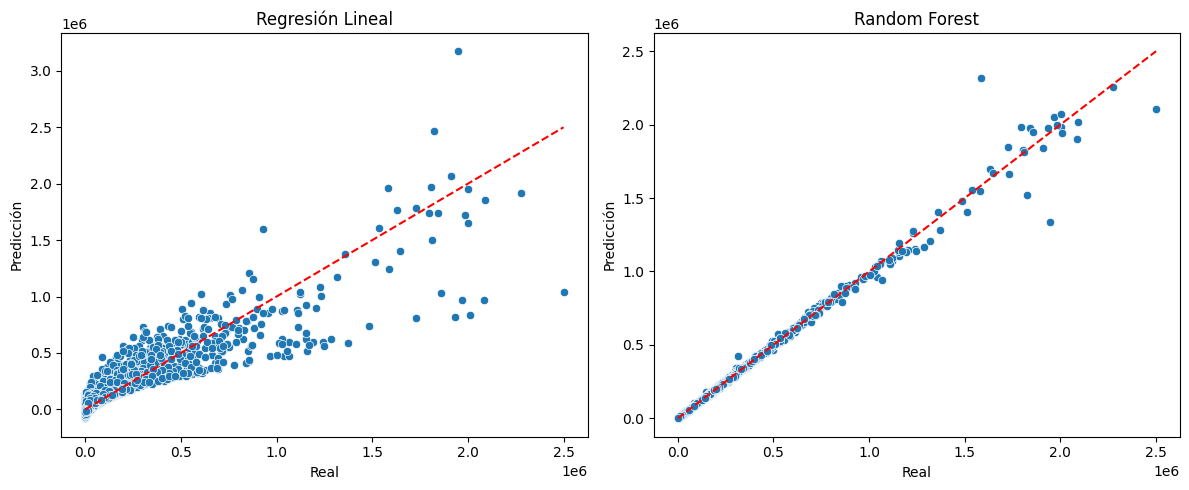

In [69]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

### Importancia de features

rf.feature_importances_ es un atributo del modelo Random‚ÄØForest entrenado con‚ÄØscikit‚Äëlearn que indica cu√°nto aporta cada variable a las predicciones del bosque. Sirve principalmente para:

- Interpretar el modelo: saber qu√© variables pesan m√°s en la toma de decisiones.

- Seleccionar variables: descartar las de baja importancia y simplificar el modelo.

In [70]:
importances = rf.feature_importances_
features = X.columns
importancia_df = pd.DataFrame({"Feature": features, "Importancia": importances})
importancia_df = importancia_df.sort_values(by="Importancia", ascending=False)

/tmp/ipython-input-71-4106902020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Feature", data=importancia_df.head(15), palette="viridis")


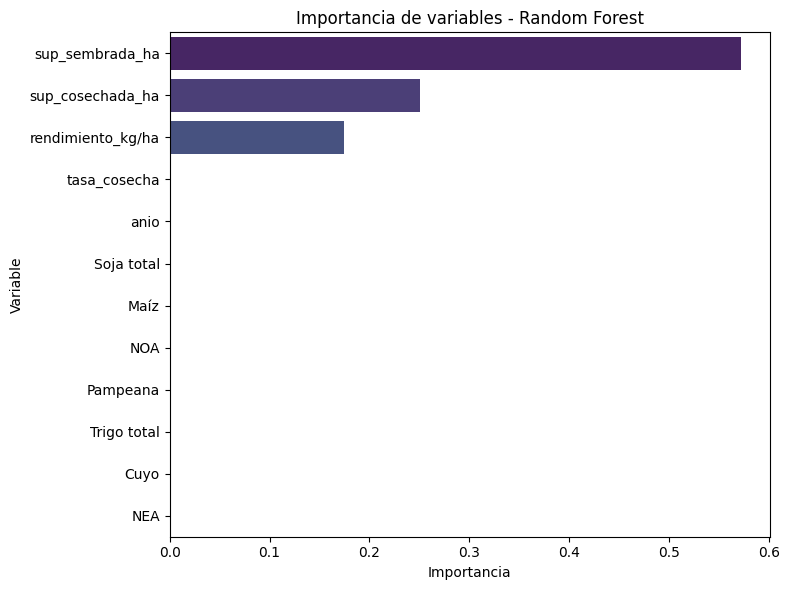

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Importancia", y="Feature", data=importancia_df.head(15), palette="viridis")
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

El modelo ha identificado que solo 3 variables contienen la mayor parte de la informaci√≥n √∫til para predecir el resultado. Las dem√°s tienen poca o ninguna relevancia en la toma de decisiones.

### Mejora de hiperpar√°metros

In [72]:
# Definir variable objetivo y predictoras seleccionadas
y = df["produccion_ton"]
X = df[["sup_sembrada_ha", "sup_cosechada_ha", "rendimiento_kg/ha"]]

In [73]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Definir modelo base
rf = RandomForestRegressor(random_state=42)

In [76]:
# Definir hiperpar√°metros a explorar
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

In [77]:
# B√∫squeda aleatoria de hiperpar√°metros
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # cantidad de combinaciones
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [78]:
# Entrenar el modelo con b√∫squeda
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [79]:
# Usar el mejor modelo encontrado
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

In [80]:
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred_best)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

In [81]:
# Imprimir resultados
print("Mejor configuraci√≥n encontrada:")
print(random_search.best_params_)

print("\nM√©tricas con el mejor modelo:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R¬≤:   {r2:.3f}")

Mejor configuraci√≥n encontrada:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}

M√©tricas con el mejor modelo:
  MAE:  1149.99
  RMSE: 12593.64
  R¬≤:   0.995


In [83]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACI√ìN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R¬≤ train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R¬≤ val:     {cv_results['test_r2'].mean():.3f}")



VALIDACI√ìN CRUZADA (5-fold):
  MAE train:  488.60
  MAE val:    1299.11
  RMSE train: 4291.48
  RMSE val:   12671.77
  R¬≤ train:   0.999
  R¬≤ val:     0.995



MAE (Mean Absolute Error): Mide el error promedio en las predicciones. Cuanto m√°s bajo, mejor.

RMSE (Root Mean Squared Error): Penaliza m√°s los errores grandes (cuadr√°tico). Tambi√©n, m√°s bajo es mejor.

R¬≤ (Coeficiente de determinaci√≥n): Mide qu√© tan bien explica el modelo la variaci√≥n de la variable objetivo. Valor entre 0 y 1.


- Un MAE de 1299 representa apenas un 1% o menos del valor t√≠pico.

- Un RMSE de 12.672 suena grande, pero tiene sentido si hay algunos valores extremos.

- Un R¬≤ de 0.995 en validaci√≥n es excelente, indica que se explica el 99.5% de la variabilidad.

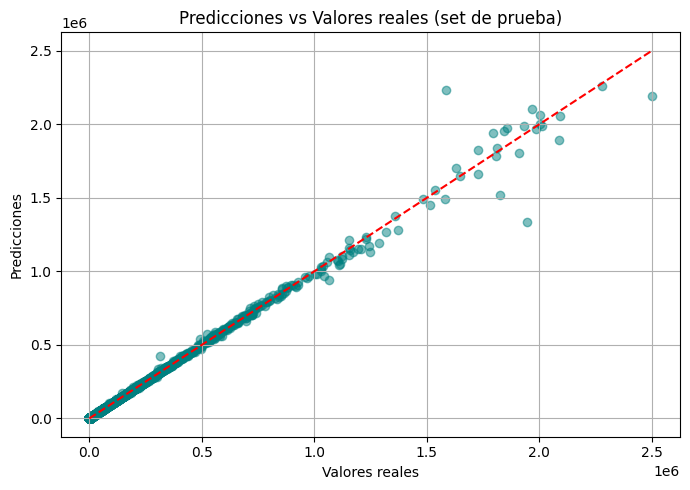

In [85]:
import matplotlib.pyplot as plt

y_pred = best_rf.predict(X_test)

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo generaliza muy bien en el set de prueba. No hay grandes desviaciones ni agrupamientos raros.

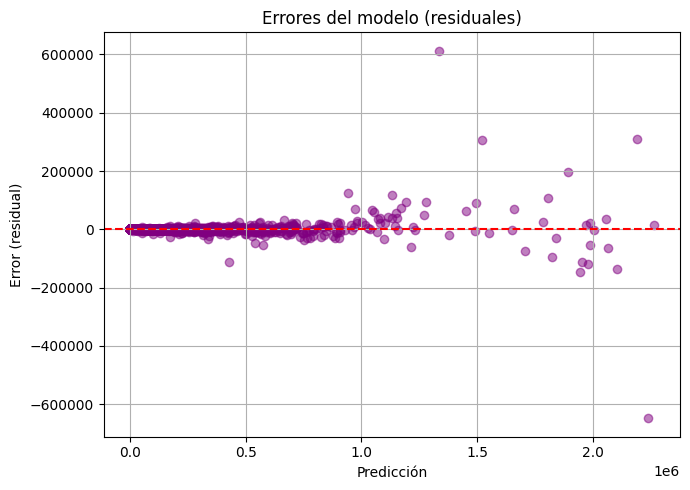

In [86]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicci√≥n')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo no muestra sesgos evidentes. El error crece un poco para valores altos (esperable en datos con mayor varianza), pero no hay indicios fuertes de sobreajuste ni de mala especificaci√≥n del modelo.

## **Modelo supervisado por cultivo**

Decidimos entrenar un modelo espec√≠fico para cada cultivo, ya que cada uno tiene din√°micas propias, distintos factores clim√°ticos, tecnol√≥gicos y de mercado que impactan en su producci√≥n.

### Cultivo: Ma√≠z

Predecir la producci√≥n (en toneladas) de ma√≠z para distintos a√±os, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresi√≥n Lineal

- Random Forest Regressor (con b√∫squeda de hiperpar√°metros)

In [87]:
# Filtramos dataset por cultivo ma√≠z
df_maiz = df[df['cultivo'] == 'Ma√≠z'].copy()

#Variables del modelo
X_maiz = df_maiz[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_maiz = df_maiz['produccion_ton']

# Codificaci√≥n de la regi√≥n
X_maiz = pd.get_dummies(X_maiz, columns=['region'], drop_first=True)

In [88]:
from sklearn.model_selection import train_test_split

X_train_maiz, X_test_maiz, y_train_maiz, y_test_maiz = train_test_split(X_maiz, y_maiz, test_size=0.2, random_state=42)

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresi√≥n Lineal
lr_maiz = LinearRegression()
lr_maiz.fit(X_train_maiz, y_train_maiz)
y_pred_lr_maiz = lr_maiz.predict(X_test_maiz)

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_maiz = RandomForestRegressor(n_estimators=100, random_state=42)
rf_maiz.fit(X_train_maiz, y_train_maiz)
y_pred_rf_maiz = rf_maiz.predict(X_test_maiz)

In [91]:
# Metricas
rms_maiz_rf = mean_squared_error(y_test_maiz, y_pred_rf_maiz)
mae_maiz_rf = mean_absolute_error(y_test_maiz, y_pred_rf_maiz)
r2_maiz_rf = r2_score(y_test_maiz, y_pred_rf_maiz)

rms_maiz_l = mean_squared_error(y_test_maiz, y_pred_lr_maiz)
mae_maiz_l = mean_absolute_error(y_test_maiz, y_pred_lr_maiz)
r2_maiz_l = r2_score(y_test_maiz, y_pred_lr_maiz)

print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_maiz_l:.2f} | R¬≤: {r2_maiz_l:.2f} | RMS: {rms_maiz_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_maiz_rf:.2f} | R¬≤: {r2_maiz_rf:.2f} | RMS: {rms_maiz_rf:.2f}')

Metricas para Regresi√≥n Lineal: MAE: 27990.84 | R¬≤: 0.84 | RMS: 4861031019.61
Metricas para Random Forest: MAE: 11255.85 | R¬≤: 0.96 | RMS: 1170666544.74


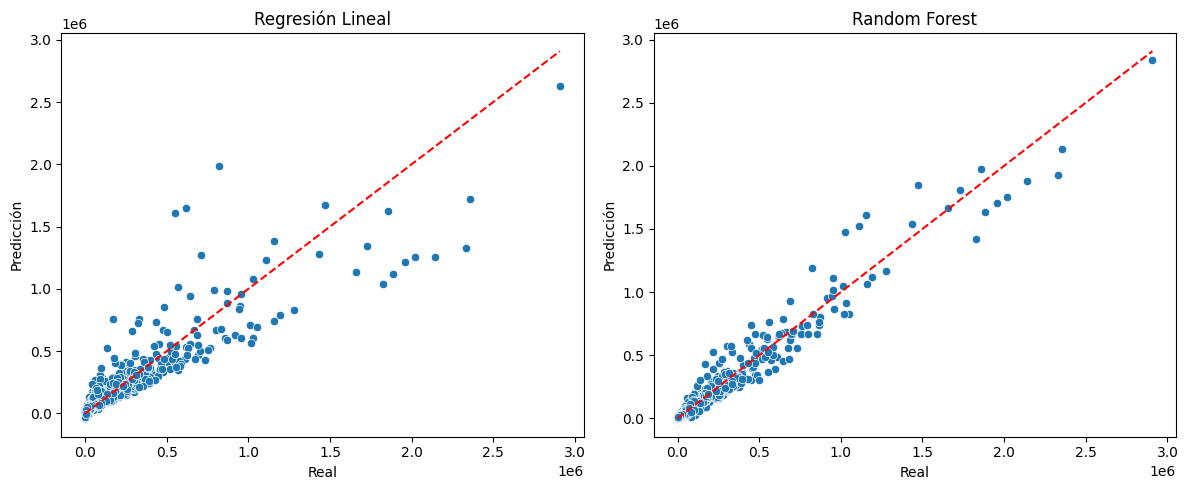

In [92]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_maiz, y=y_pred_lr_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_maiz, y=y_pred_rf_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

Hiperpar√°metros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # M√°s √°rboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qu√© fracci√≥n de features se considera}

# RandomizedSearch
#random_search_maiz = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cu√°ntas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_maiz.fit(X_train_maiz, y_train_maiz)

# Mejor modelo encontrado
#best_rf = random_search_maiz.best_estimator_
#print("Mejores hiperpar√°metros:", random_search_maiz.best_params_)


Mejores hiperpar√°metros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}


In [93]:
# modifico hiperpar√°metros
rf_model_maiz = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=None , max_depth=20, random_state=42)
rf_model_maiz.fit(X_train_maiz, y_train_maiz)

y_pred_maiz = rf_model_maiz.predict(X_test_maiz)

In [94]:
# Metricas
rms = mean_squared_error(y_test_maiz, y_pred_maiz)
mae = mean_absolute_error(y_test_maiz, y_pred_maiz)
r2 = r2_score(y_test_maiz, y_pred_maiz)


print('Modelos iniciales para Ma√≠z')
print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_maiz_l:.2f} | R¬≤: {r2_maiz_l:.2f} | RMS: {rms_maiz_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_maiz_rf:.2f} | R¬≤: {r2_maiz_rf:.2f} | RMS: {rms_maiz_rf:.2f}')
print('\n')
print('Modelos optimizados')
print(f'MAE: {mae:.2f} | R¬≤: {r2:.2f} | RMS: {rms:.2f}')

Modelos iniciales para Ma√≠z
Metricas para Regresi√≥n Lineal: MAE: 27990.84 | R¬≤: 0.84 | RMS: 4861031019.61
Metricas para Random Forest: MAE: 11255.85 | R¬≤: 0.96 | RMS: 1170666544.74


Modelos optimizados
MAE: 11188.91 | R¬≤: 0.96 | RMS: 1149125947.22


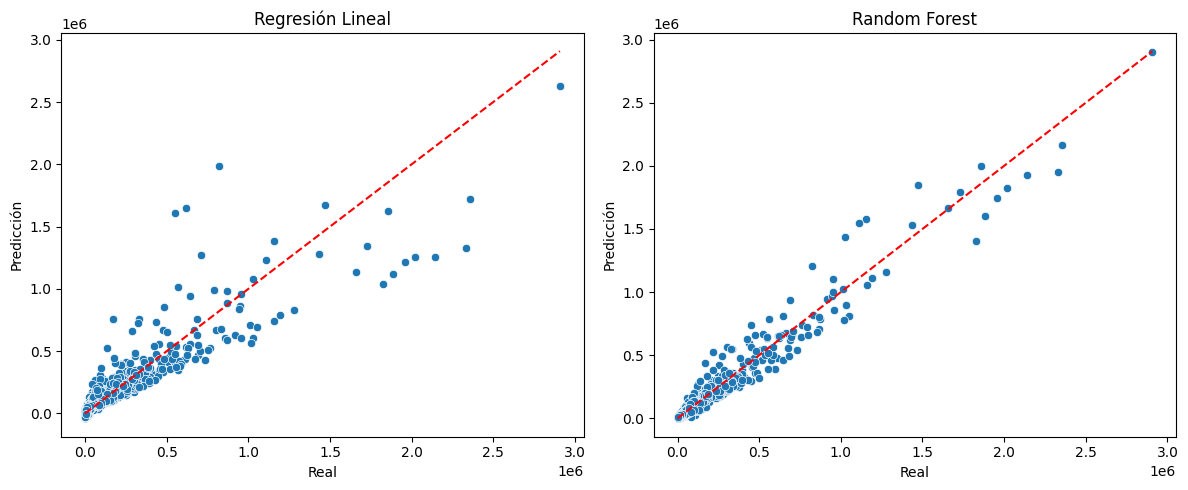

In [95]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_maiz, y=y_pred_lr_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_maiz, y=y_pred_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

La regresi√≥n lineal logra una buena relaci√≥n (R¬≤=0.83), pero a√∫n deja errores de decenas de miles de toneladas.

Random Forest reduce dr√°sticamente el error medio, mostrando que captura mejor patrones no lineales.

Optimizaci√≥n:

Con par√°metros: n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features=None se perfeccion√≥ el modelo.
La mejora fue moderada pero permiti√≥ afinar detalles que pueden ser cruciales en decisiones estrat√©gicas.

In [96]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_model_maiz,
    X_train_maiz,
    y_train_maiz,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACI√ìN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R¬≤ train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R¬≤ val:     {cv_results['test_r2'].mean():.3f}")



VALIDACI√ìN CRUZADA (5-fold):
  MAE train:  4560.59
  MAE val:    12094.93
  RMSE train: 14325.51
  RMSE val:   39435.33
  R¬≤ train:   0.993
  R¬≤ val:     0.947


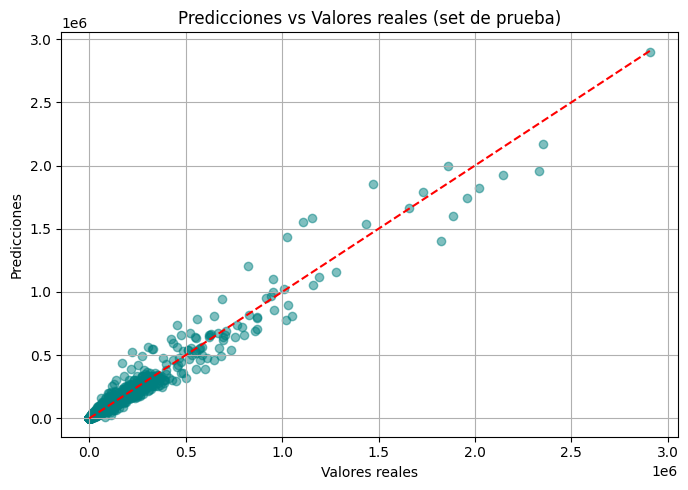

In [97]:
import matplotlib.pyplot as plt

y_pred_maiz = rf_model_maiz.predict(X_test_maiz)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_maiz, y_pred_maiz, alpha=0.5, color='teal')
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo predice muy bien en general, pero pierde algo de precisi√≥n en los valores altos. Esto es com√∫n en modelos no lineales como Random Forest cuando hay pocos ejemplos de alta magnitud o gran dispersi√≥n en ese rango.

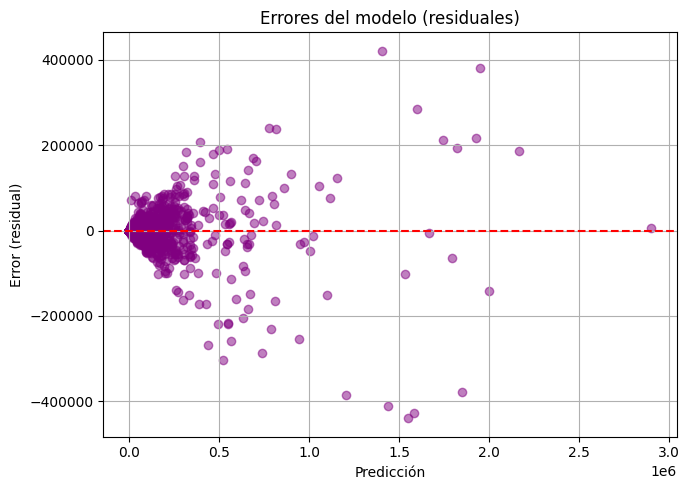

In [98]:
residuals_maiz = y_test_maiz - y_pred_maiz

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_maiz, residuals_maiz, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicci√≥n')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

No hay se√±ales evidentes de sesgo estructural. El modelo mantiene una varianza aceptable considerando que la variable objetivo est√° en millones. La mayor dispersi√≥n en valores altos podr√≠a deberse a la escasez de muestras en ese rango.

### Cultivo: Soja

Predecir la producci√≥n (en toneladas) de soja para distintos a√±os, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresi√≥n Lineal

- Random Forest Regressor (con b√∫squeda de hiperpar√°metros)

In [99]:
# Filtramos dataset por cultivo soja
df_soja = df[df['cultivo'] == 'Soja total'].copy()

#Variables del modelo
X_soja = df_soja[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_soja = df_soja['produccion_ton']

# Codificaci√≥n de la regi√≥n
X_soja = pd.get_dummies(X_soja, columns=['region'], drop_first=True)

In [100]:
from sklearn.model_selection import train_test_split

X_train_soja, X_test_soja, y_train_soja, y_test_soja = train_test_split(X_soja, y_soja, test_size=0.2, random_state=42)

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresi√≥n Lineal
lr_soja = LinearRegression()
lr_soja.fit(X_train_soja, y_train_soja)
y_pred_lr_soja = lr_soja.predict(X_test_soja)

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_soja = RandomForestRegressor(n_estimators=100, random_state=42)
rf_soja.fit(X_train_soja, y_train_soja)
y_pred_rf_soja = rf_soja.predict(X_test_soja)

In [103]:
# Metricas
rms_soja_rf = mean_squared_error(y_test_soja, y_pred_rf_soja)
mae_soja_rf = mean_absolute_error(y_test_soja, y_pred_rf_soja)
r2_soja_rf = r2_score(y_test_soja, y_pred_rf_soja)

rms_soja_l = mean_squared_error(y_test_soja, y_pred_lr_soja)
mae_soja_l = mean_absolute_error(y_test_soja, y_pred_lr_soja)
r2_soja_l = r2_score(y_test_soja, y_pred_lr_soja)

print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_soja_l:.2f} | R¬≤: {r2_soja_l:.2f} | RMS: {rms_soja_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_soja_rf:.2f} | R¬≤: {r2_soja_rf:.2f} | RMS: {rms_soja_rf:.2f}')

Metricas para Regresi√≥n Lineal: MAE: 26247.54 | R¬≤: 0.94 | RMS: 3624901577.65
Metricas para Random Forest: MAE: 19815.99 | R¬≤: 0.95 | RMS: 3031742460.48


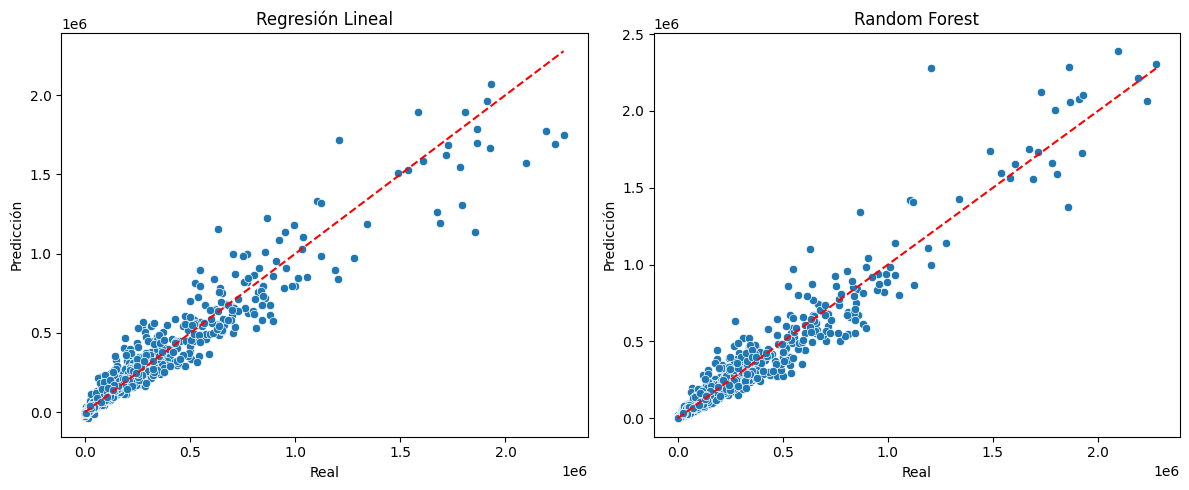

In [104]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_soja, y=y_pred_lr_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_soja, y=y_pred_rf_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

Hiperpar√°metros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # M√°s √°rboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qu√© fracci√≥n de features se considera}

# RandomizedSearch
#random_search_soja = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cu√°ntas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_soja.fit(X_train_soja, y_train_soja)

# Mejor modelo encontrado
#best_rf = random_search_soja.best_estimator_
#print("Mejores hiperpar√°metros:", random_search_soja.best_params_)


Mejores hiperpar√°metros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}

In [105]:
# modifico hiperpar√°metros
rf_model_soja = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features='sqrt' , max_depth= 20, random_state=42)
rf_model_soja.fit(X_train_soja, y_train_soja)

y_pred_soja = rf_model_soja.predict(X_test_soja)

In [106]:
# Metricas
rms = mean_squared_error(y_test_soja, y_pred_soja)
mae = mean_absolute_error(y_test_soja, y_pred_soja)
r2 = r2_score(y_test_soja, y_pred_soja)


print('Modelos iniciales Soja')
print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_soja_l:.2f} | R¬≤: {r2_soja_l:.2f} | RMS: {rms_soja_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_soja_rf:.2f} | R¬≤: {r2_soja_rf:.2f} | RMS: {rms_soja_rf:.2f}')
print('\n')
print('Modelos optimizados')
print(f'MAE: {mae:.2f} | R¬≤: {r2:.2f} | RMS: {rms:.2f}')

Modelos iniciales Soja
Metricas para Regresi√≥n Lineal: MAE: 26247.54 | R¬≤: 0.94 | RMS: 3624901577.65
Metricas para Random Forest: MAE: 19815.99 | R¬≤: 0.95 | RMS: 3031742460.48


Modelos optimizados
MAE: 19250.19 | R¬≤: 0.95 | RMS: 2834447325.71


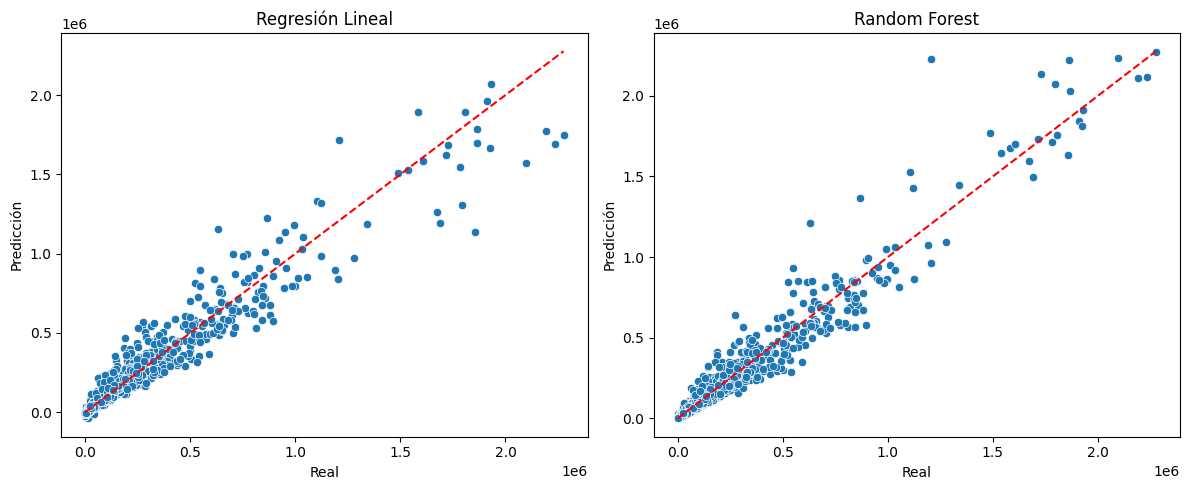

In [107]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_soja, y=y_pred_lr_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_soja, y=y_pred_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

La soja present√≥ patrones algo m√°s sencillos comparados con el ma√≠z, por lo que el modelo base ya rend√≠a muy bien. La optimizaci√≥n ajust√≥ algunos detalles reforzando la robustez sin cambiar radicalmente las m√©tricas.

In [108]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_model_soja,
    X_train_soja,
    y_train_soja,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACI√ìN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R¬≤ train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R¬≤ val:     {cv_results['test_r2'].mean():.3f}")



VALIDACI√ìN CRUZADA (5-fold):
  MAE train:  11736.57
  MAE val:    19634.88
  RMSE train: 31750.42
  RMSE val:   52629.85
  R¬≤ train:   0.981
  R¬≤ val:     0.948


La diferencia entre entrenamiento y validaci√≥n no es exagerada, lo cual indica buena generalizaci√≥n y sin overfitting severo.

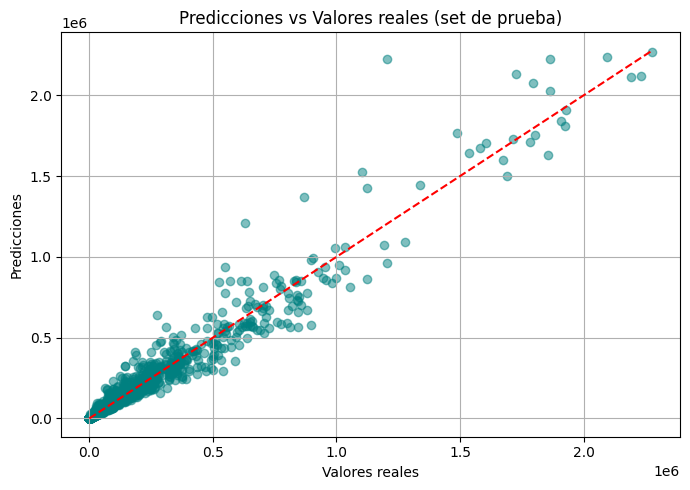

In [109]:
import matplotlib.pyplot as plt

y_pred_soja = rf_model_soja.predict(X_test_soja)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_soja, y_pred_soja, alpha=0.5, color='teal')
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


En los valores altos, algunas predicciones subestiman un poco. En general, el modelo capta bien la tendencia global.

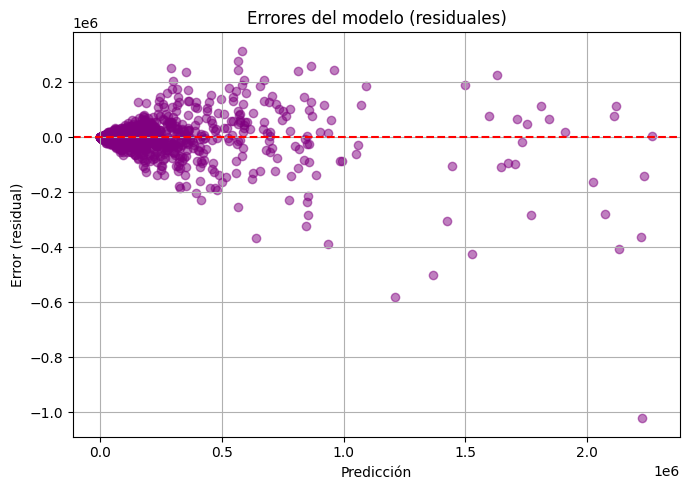

In [110]:
residuals_soja = y_test_soja - y_pred_soja

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_soja, residuals_soja, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicci√≥n')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo tiene m√°s dificultad con los valores m√°s grandes, posiblemente por menor cantidad de muestras en ese rango.

### Cultivo: Trigo

Predecir la producci√≥n (en toneladas) de trigo para distintos a√±os, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresi√≥n Lineal

- Random Forest Regressor (con b√∫squeda de hiperpar√°metros)

In [111]:
# Filtramos dataset por cultivo trigo
df_trigo = df[df['cultivo'] == 'Trigo total'].copy()

#Variables del modelo
X_trigo = df_trigo[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_trigo = df_trigo['produccion_ton']

# Codificaci√≥n de la regi√≥n
X_trigo = pd.get_dummies(X_trigo, columns=['region'], drop_first=True)

In [112]:
from sklearn.model_selection import train_test_split

X_train_trigo, X_test_trigo, y_train_trigo, y_test_trigo = train_test_split(X_trigo, y_trigo, test_size=0.2, random_state=42)

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresi√≥n Lineal
lr_trigo = LinearRegression()
lr_trigo.fit(X_train_trigo, y_train_trigo)
y_pred_lr_trigo = lr_trigo.predict(X_test_trigo)

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_trigo = RandomForestRegressor(n_estimators=100, random_state=42)
rf_trigo.fit(X_train_trigo, y_train_trigo)
y_pred_rf_trigo = rf_trigo.predict(X_test_trigo)

In [115]:
# Metricas
rms_trigo_rf = mean_squared_error(y_test_trigo, y_pred_rf_trigo)
mae_trigo_rf = mean_absolute_error(y_test_trigo, y_pred_rf_trigo)
r2_trigo_rf = r2_score(y_test_trigo, y_pred_rf_trigo)

rms_trigo_l = mean_squared_error(y_test_trigo, y_pred_lr_trigo)
mae_trigo_l = mean_absolute_error(y_test_trigo, y_pred_lr_trigo)
r2_trigo_l = r2_score(y_test_trigo, y_pred_lr_trigo)

print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_trigo_l:.2f} | R¬≤: {r2_trigo_l:.2f} | RMS: {rms_trigo_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_trigo_rf:.2f} | R¬≤: {r2_trigo_rf:.2f} | RMS: {rms_trigo_rf:.2f}')

Metricas para Regresi√≥n Lineal: MAE: 17655.14 | R¬≤: 0.86 | RMS: 1005743249.05
Metricas para Random Forest: MAE: 11720.09 | R¬≤: 0.89 | RMS: 776703048.07


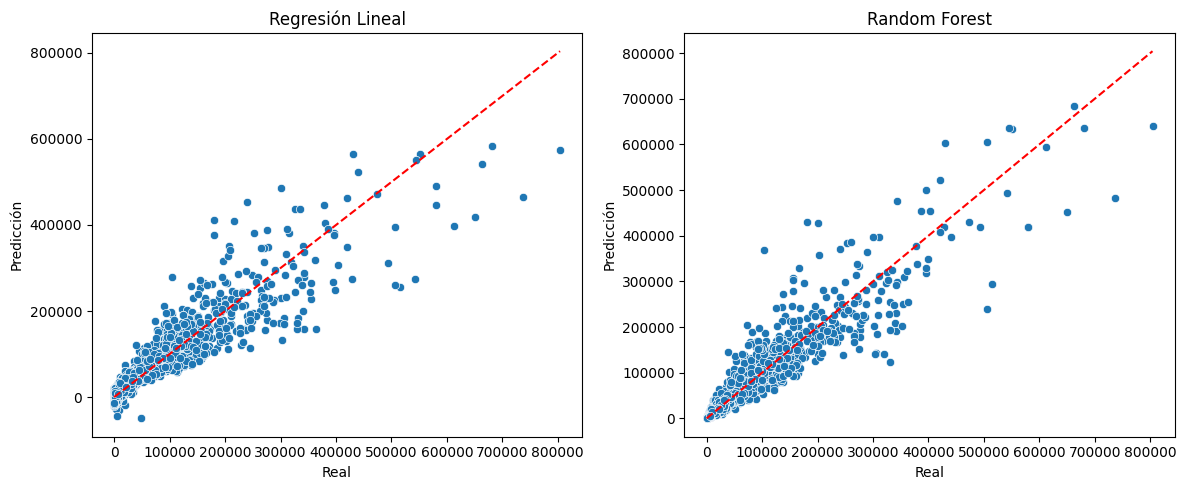

In [116]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_trigo, y=y_pred_lr_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_trigo, y=y_pred_rf_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

Hiperpar√°metros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # M√°s √°rboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qu√© fracci√≥n de features se considera}

# RandomizedSearch
#random_search_trigo = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cu√°ntas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_trigo.fit(X_train_trigo, y_train_trigo)

# Mejor modelo encontrado
#best_rf = random_search_trigo.best_estimator_
#print("Mejores hiperpar√°metros:", random_search_trigo.best_params_)


Mejores hiperpar√°metros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [117]:
# modifico hiperpar√°metros
rf_modelo_trigo = RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features='log2' , max_depth=30, random_state=42)
rf_modelo_trigo.fit(X_train_trigo, y_train_trigo)

y_pred_trigo = rf_modelo_trigo.predict(X_test_trigo)

In [118]:
# Metricas
rms = mean_squared_error(y_test_trigo, y_pred_trigo)
mae = mean_absolute_error(y_test_trigo, y_pred_trigo)
r2 = r2_score(y_test_trigo, y_pred_trigo)

print('Metricas inciales trigo')
print(f'Metricas para Regresi√≥n Lineal: MAE: {mae_trigo_l:.2f} | R¬≤: {r2_trigo_l:.2f} | RMS: {rms_trigo_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_trigo_rf:.2f} | R¬≤: {r2_trigo_rf:.2f} | RMS: {rms_trigo_rf:.2f}')
print('\n')
print('Metricas optimizadas')
print(f'MAE: {mae:.2f} | R¬≤: {r2:.2f} | RMS: {rms:.2f}')

Metricas inciales trigo
Metricas para Regresi√≥n Lineal: MAE: 17655.14 | R¬≤: 0.86 | RMS: 1005743249.05
Metricas para Random Forest: MAE: 11720.09 | R¬≤: 0.89 | RMS: 776703048.07


Metricas optimizadas
MAE: 11217.47 | R¬≤: 0.90 | RMS: 662973094.13


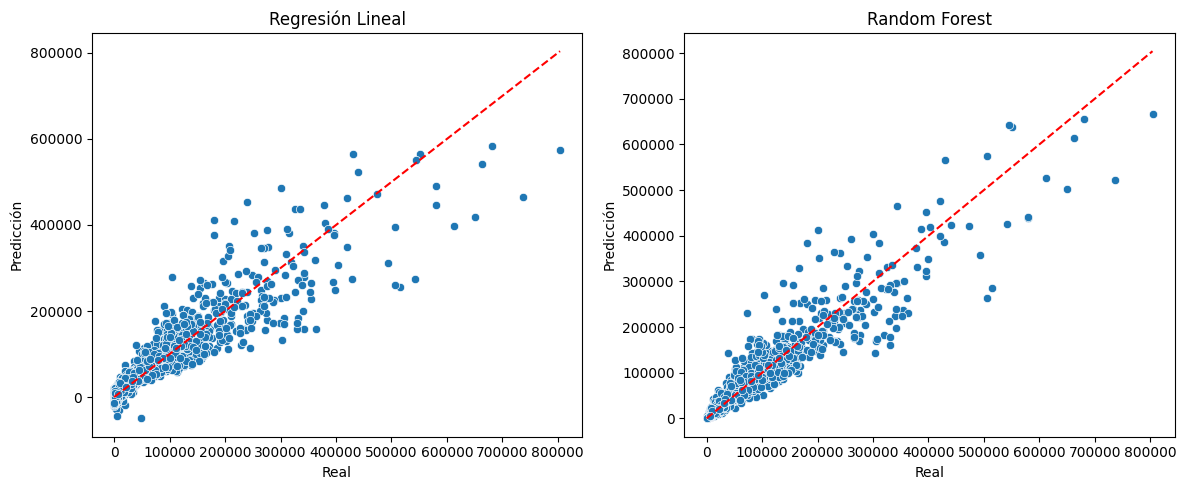

In [119]:
# Visualizaci√≥n comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_trigo, y=y_pred_lr_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Regresi√≥n Lineal")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_trigo, y=y_pred_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicci√≥n")

plt.tight_layout()
plt.show()

El trigo mostr√≥ una estructura productiva algo intermedia entre soja y ma√≠z. El Random Forest captur√≥ relaciones m√°s complejas que la lineal, y la afinaci√≥n de hiperpar√°metros reforz√≥ a√∫n m√°s la exactitud.

El modelo Random Forest optimizado es el candidato ideal para cada cultivo. Proporciona predicciones confiables para planificaci√≥n, estimaci√≥n de stock, precios o impacto clim√°tico.

In [120]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_modelo_trigo,
    X_train_trigo,
    y_train_trigo,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACI√ìN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R¬≤ train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R¬≤ val:     {cv_results['test_r2'].mean():.3f}")



VALIDACI√ìN CRUZADA (5-fold):
  MAE train:  8719.07
  MAE val:    12486.64
  RMSE train: 21203.72
  RMSE val:   30703.61
  R¬≤ train:   0.945
  R¬≤ val:     0.884


La peque√±a ca√≠da de R¬≤ (de 0.945 a 0.884) y el incremento moderado de los errores indican que el modelo no est√° sobreajustado, aunque s√≠ hay una p√©rdida de precisi√≥n, especialmente en los extremos.

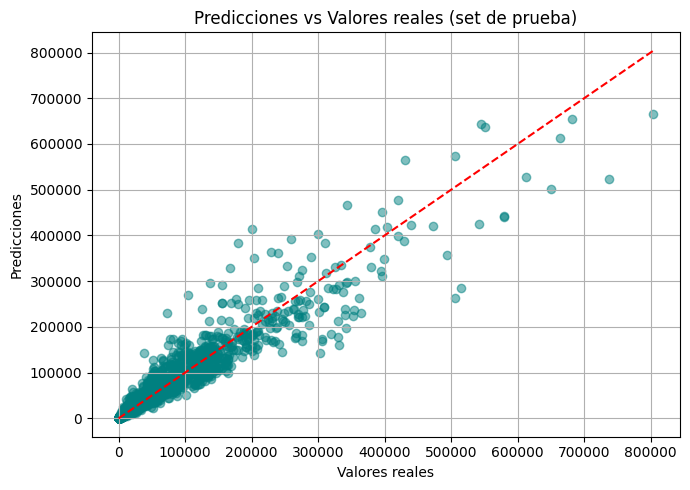

In [121]:
import matplotlib.pyplot as plt

y_pred_trigo = rf_modelo_trigo.predict(X_test_trigo)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_trigo, y_pred_trigo, alpha=0.5, color='teal')
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


En valores de producci√≥n altos (mayores a 100 mil), el modelo subestima la producci√≥n (los puntos est√°n por debajo de la l√≠nea diagonal).

En producciones bajas y medias, el ajuste es mucho m√°s preciso.

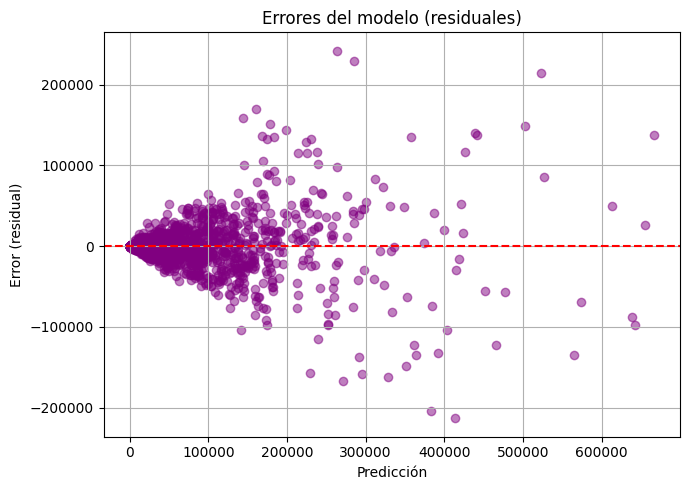

In [122]:
residuals_trigo = y_test_trigo - y_pred_trigo

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_trigo, residuals_trigo, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicci√≥n')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

Hay una leve dispersi√≥n hacia la derecha (errores positivos m√°s frecuentes), lo que refuerza la idea de que el modelo tiende a subestimar en ciertos casos.

No hay colas exageradas ni outliers extremos, lo que indica que el modelo es estable.

## **Comentarios finales**

A pesar de que el modelo entrenado sobre el dataset completo ‚Äîes decir, sin distinguir entre cultivos‚Äî present√≥ un rendimiento global sobresaliente (R¬≤ = 0,995; MAE = 1.121,57), se opt√≥ por construir modelos espec√≠ficos para cada cultivo (soja, ma√≠z y trigo). Esta decisi√≥n se fundamenta en tres razones principales. En primer lugar, cada cultivo responde de manera distinta a las variables agroclim√°ticas y ed√°ficas, lo cual se traduce en relaciones particulares que un √∫nico modelo no logra capturar con precisi√≥n. En segundo lugar, al trabajar con un modelo general, existe el riesgo de que se favorezca al cultivo predominante en t√©rminos de volumen o cantidad de registros, afectando negativamente la capacidad de predicci√≥n sobre los dem√°s. Por √∫ltimo, los modelos separados permiten estimaciones espec√≠ficas de producci√≥n por cultivo, lo cual es esencial para la toma de decisiones agron√≥micas, econ√≥micas y de pol√≠tica p√∫blica. En todos los casos, los modelos individuales alcanzaron niveles de ajuste satisfactorios (R¬≤ ‚â• 0,90), lo que confirma la validez de esta estrategia.